### Tasks
#### Replace Exact neighbors with LSH

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
import time
import copy

#replace with pytorch lightning
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

In [2]:
random.seed(123)

In [3]:
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
print(device)

cuda:7


In [4]:
df=pd.read_csv("HIGGS.csv",header=None, nrows=600000)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [5]:
print(df.size)

17400000


<AxesSubplot: xlabel='0', ylabel='count'>

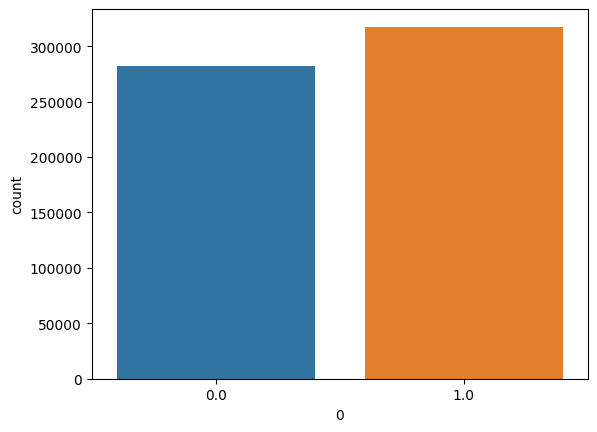

In [6]:
sns.countplot(x = 0, data=df)

In [7]:
X = df.iloc[:, 1:22]
y = df.iloc[:, 0]

In [8]:
EPOCHS = 50
BATCH_SIZE = [256, 512, 1024]
LEARNING_RATE = [0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 2

In [9]:
sweep_config = {
    'method': 'grid'
    }

parameters_dict = {
    "LEARNING_RATE": {
        'values': LEARNING_RATE
        },
    "NUM_FEATURES": {
        'value': NUM_FEATURES
        },
    "NUM_CLASSES": {
        'value': NUM_CLASSES
        },
    "EPOCHS": {
        'value': EPOCHS
        },
    "BATCH_SIZE":{
        'values':BATCH_SIZE
        }
    }
# 
sweep_config['parameters'] = parameters_dict

In [10]:
sweep_id = wandb.sweep(sweep_config, project="Tuning-Hyperparameters")

Create sweep with ID: 26265fe4
Sweep URL: https://wandb.ai/lsh_batches/Tuning-Hyperparameters/sweeps/26265fe4


In [11]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [12]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [13]:
def get_class_distribution(obj):
    count_dict = {
        "class_0": 0,
        "class_1": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['class_0'] += 1
        elif i == 1: 
            count_dict['class_1'] += 1           
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

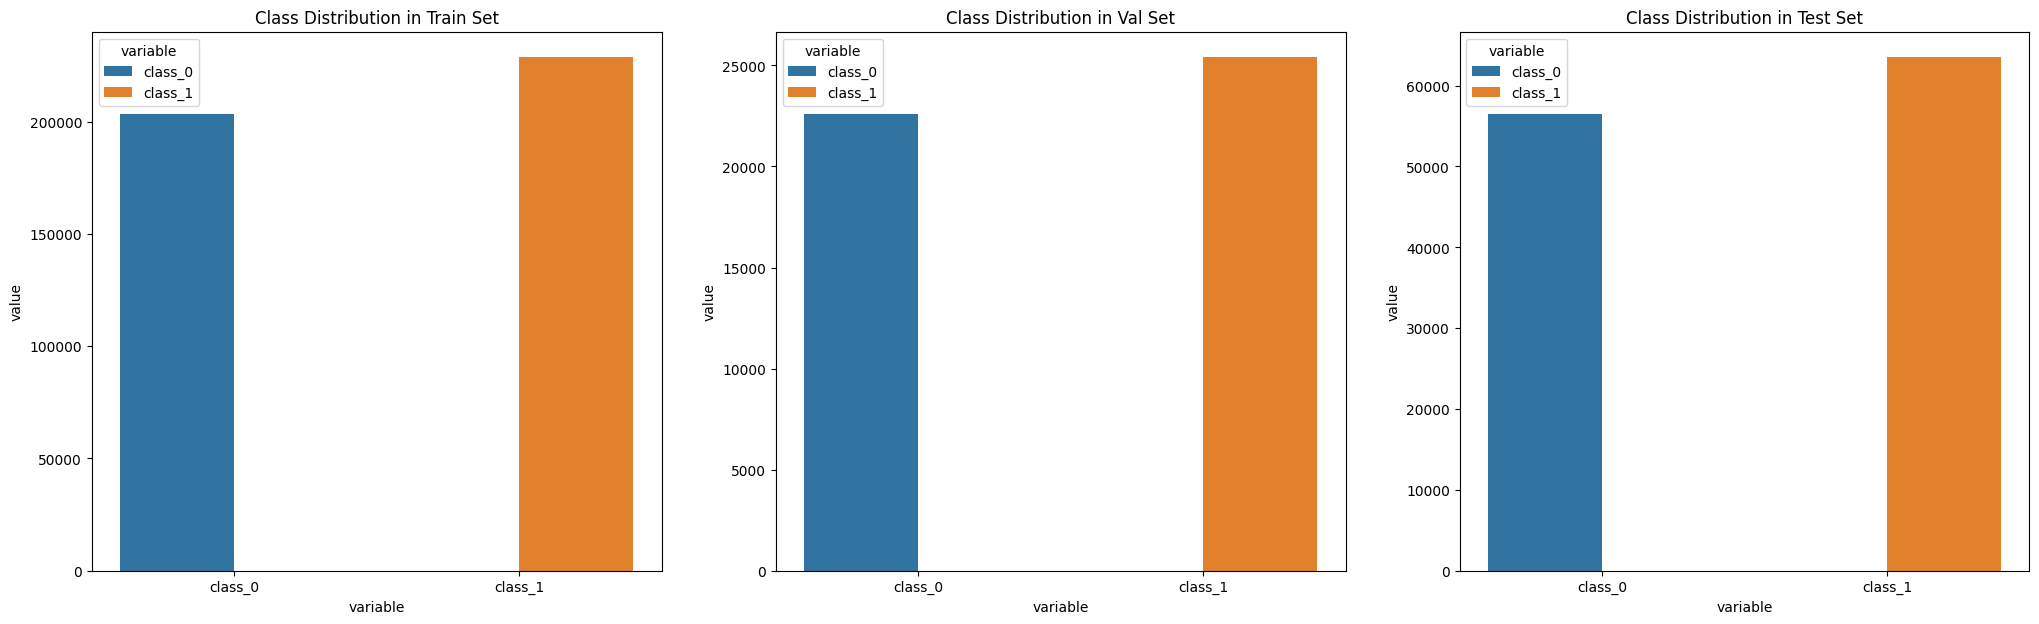

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [15]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

train_dataset = ClassifierDataset(torch.tensor(X_train, dtype=torch.float32 ,device=device), torch.tensor(y_train, dtype=torch.float32, device=device))
val_dataset = ClassifierDataset(torch.tensor(X_val, dtype=torch.float32, device=device), torch.tensor(y_val, dtype=torch.float32, device=device))
test_dataset = ClassifierDataset(torch.tensor(X_test, dtype=torch.float32, device=device), torch.tensor(y_test, dtype=torch.float32, device=device))

In [16]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 500)
        self.layer_2 = nn.Linear(500, 500)
        self.layer_3 = nn.Linear(500, 500)
        self.layer_out = nn.Linear(500, 1) 
        
        self.relu = nn.ReLU()

        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.relu(x)
        
        x = self.layer_3(x)
        x = self.relu(x)
        
        x = self.layer_out(x)
        x = torch.sigmoid(x)
        
        return x

In [17]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [18]:
base_model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
base_model.to(device)

MulticlassClassification(
  (layer_1): Linear(in_features=21, out_features=500, bias=True)
  (layer_2): Linear(in_features=500, out_features=500, bias=True)
  (layer_3): Linear(in_features=500, out_features=500, bias=True)
  (layer_out): Linear(in_features=500, out_features=1, bias=True)
  (relu): ReLU()
)

In [19]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": [],
    "grad": []
}

In [20]:
def wandb_trainer_function(config=None):
    # INITIALIZE NEW WANDB RUN
    with wandb.init(config=config) as run:
        #USING THE CONFIG TO SET THE HYPERPARAMETERS FOR EACH RUN
#         config = wandb.config
#         wandb.define_metric("custom_step")
#         wandb.define_metric("Train Loss", step_metric='custom_step')
#         wandb.define_metric("Val Loss", step_metric='custom_step')
#         wandb.define_metric("Train Accuracy", step_metric='custom_step')
#         wandb.define_metric("Val Accuracy", step_metric='custom_step')

#         run.name = "NN-" + str(config.BATCH_SIZE) + "-" + str(config.LEARNING_RATE)
        
        model = copy.deepcopy(base_model)

        criterion = torch.nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE[0])
        
        
        train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE[0])
        val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE[0])
        
        print("Begin training.")
        for e in tqdm(range(1, EPOCHS+1)):
            train_epoch_loss=0
            train_epoch_acc=0
            val_epoch_loss = 0
            val_epoch_acc = 0

            model.train()
  
            for X, y in train_loader:
                optimizer.zero_grad()
               
                pred = torch.flatten(model(X))
                
                train_loss = criterion(pred, y)
                train_acc = multi_acc(pred, y)
                
                train_epoch_loss += train_loss.item()
                train_epoch_acc += train_acc.item()
                
                train_loss.backward()
                optimizer.step()


            with torch.no_grad():
                model.eval()
                for X_val, y_val in val_loader:
                    val_pred = torch.flatten(model(X_val))

                    val_loss = criterion(val_pred, y_val)
                    val_acc = multi_acc(val_pred, y_val)

                    val_epoch_loss += val_loss.item()
                    val_epoch_acc += val_acc.item()


            # TRAIN LOSS AND ACCURACY
            loss_stats['train'].append(train_epoch_loss/(len(train_loader)))
            loss_stats['val'].append(val_epoch_loss/(len(val_loader)))
        
            accuracy_stats['train'].append(train_epoch_acc/(len(train_loader)))
            accuracy_stats['val'].append(val_epoch_acc/(len(val_loader)))

            ## plot val loss and accuracy here. For train, standardise a subset for loss/accuracy
            print(f'Epoch {e+0:03}: | Train Loss: {loss_stats["train"][-1]:.5f} | Val Loss: {loss_stats["val"][-1]:.5f} | Train Acc: {accuracy_stats["train"][-1]:.3f} | Val Acc: {accuracy_stats["val"][-1]:.3f}')
            wandb.log({"Train Loss":loss_stats["train"][-1], "Val Loss":loss_stats["val"][-1],"Train Accuracy":accuracy_stats["train"][-1],"Val Accuracy":accuracy_stats["val"][-1], 'custom_step':e})

In [21]:
wandb.agent(sweep_id, wandb_trainer_function)

wandb: Agent Starting Run: l45rygls with config:
wandb: 	BATCH_SIZE: 256
wandb: 	EPOCHS: 50
wandb: 	LEARNING_RATE: 0.001
wandb: 	NUM_CLASSES: 2
wandb: 	NUM_FEATURES: 21
wandb: Currently logged in as: aw82 (lsh_batches). Use `wandb login --relogin` to force relogin


Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

Run l45rygls errored: IndexError('Dimension out of range (expected to be in range of [-1, 0], but got 1)')
wandb: ERROR Run l45rygls errored: IndexError('Dimension out of range (expected to be in range of [-1, 0], but got 1)')
wandb: Agent Starting Run: d0o277rc with config:
wandb: 	BATCH_SIZE: 256
wandb: 	EPOCHS: 50
wandb: 	LEARNING_RATE: 0.0001
wandb: 	NUM_CLASSES: 2
wandb: 	NUM_FEATURES: 21


Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

Run d0o277rc errored: IndexError('Dimension out of range (expected to be in range of [-1, 0], but got 1)')
wandb: ERROR Run d0o277rc errored: IndexError('Dimension out of range (expected to be in range of [-1, 0], but got 1)')
wandb: Agent Starting Run: ui2zrhxi with config:
wandb: 	BATCH_SIZE: 256
wandb: 	EPOCHS: 50
wandb: 	LEARNING_RATE: 1e-05
wandb: 	NUM_CLASSES: 2
wandb: 	NUM_FEATURES: 21


Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

Run ui2zrhxi errored: IndexError('Dimension out of range (expected to be in range of [-1, 0], but got 1)')
wandb: ERROR Run ui2zrhxi errored: IndexError('Dimension out of range (expected to be in range of [-1, 0], but got 1)')
Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: ERROR Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: To disable this check set WANDB_AGENT_DISABLE_FLAPPING=true


In [22]:
%pdb off

Automatic pdb calling has been turned OFF


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

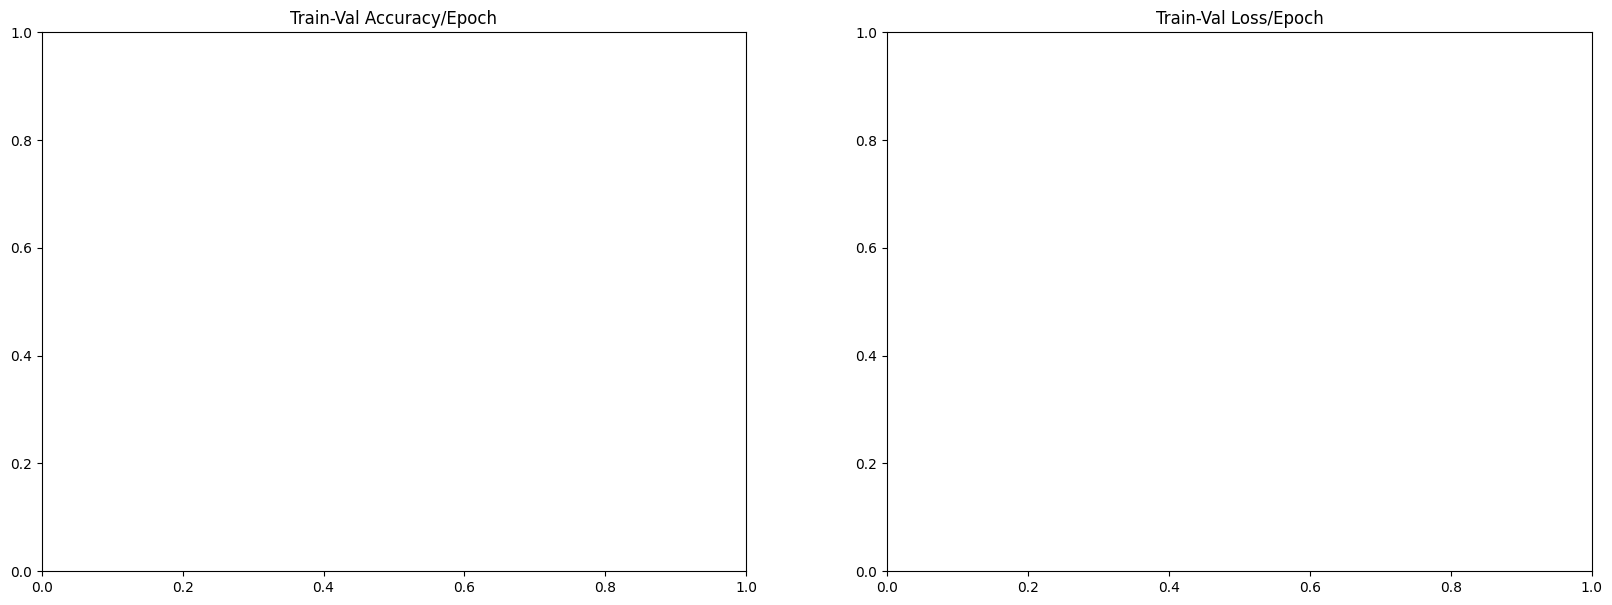

In [23]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')